In [1]:
## Fast Import
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os
import string
import pathlib
import time
import math, random
import pprint
import yaml
from collections import OrderedDict
from tqdm import tqdm

import cv2, PIL
import SimpleITK as sitk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import albumentations as A

# Others
np.set_printoptions(precision=3)

# import rere base package & subpackages
curr_path = pathlib.Path(os.getcwd())
base_path = str(curr_path.parent.parent)
if base_path not in sys.path:
    sys.path.append(base_path)

import dmt
from dmt.utils import timers
from dmt.utils.io import files, images2d, images3d
from dmt.utils.images import visualize, np_image as nim_utils

from dmt.data import (Image, ScalarImage2D, ScalarImage3D, VectorImage2D,
                        ScalarMask2D, ScalarMask3D, CategoricalLabel,
                        Sample, SampleSet)


sw = timers.StopWatch()
test_images_d = {
    'gray': str(curr_path.parent / 'images' / 'gray_sample.png'),
    'rgb': str(curr_path.parent / 'images' / 'rgb_sample.jpg'),
    'bin': str(curr_path.parent / 'images' / 'bin_sample.png'),
    'bin3d': str(curr_path.parent / 'images' / 'bin3d_sample.nii.gz'),
    'gray3d': str(curr_path.parent / 'images' / 'gray3d_sample.nii.gz'),
    'gray3d_ni': str(curr_path.parent / 'images' / 'gray3d_sample_nonisotropic.nii.gz'),
    'bcv': str(curr_path.parent / 'images' / 'bcv.nii.gz'),
    'kits': str(curr_path.parent / 'images' / 'kits.nii.gz'),
    'liver': str(curr_path.parent / 'images' / 'liver_0.nii.gz'),
    'lung': str(curr_path.parent / 'images' / 'lung_038.nii.gz'),
    'pancreas': str(curr_path.parent / 'images' / 'pancreas_001.nii.gz'),
}

def get_image_memory(image, disp=True):
    if isinstance(image, sitk.SimpleITK.Image):
        import re
        regex = r"Size: [\d]+"
        matches = re.findall(regex, str(image))[0]
        if disp:
            print('Sitk ' + matches + ' bytes')
        return int(matches.split()[-1])
    elif isinstance(image, np.ndarray):
        bytes = sys.getsizeof(image)
        if disp:
            print(f'print Size: {bytes} bytes')
        return bytes

def print_memory(image):  # backward compat.
    get_image_memory(image, disp=True)
    

In [2]:
def create_sample(args):
    sys.path.append('/Users/charzhar/Desktop/[Project] Deep Medical Tools')
    from dmt.data import (Image, ScalarImage2D, ScalarImage3D, VectorImage2D,
                        ScalarMask2D, ScalarMask3D, CategoricalLabel,
                        Sample, SampleSet)
    
    img_path, lab_path, name, idx = args
    cns = ['background', 'pancreas', 'tumor']
    image = ScalarImage3D(img_path, sitk.sitkInt16, 
                          permanent_load=False, name=name)
    label = ScalarMask3D(lab_path, cns, container_type=sitk.sitkUInt8)
    label2 = CategoricalLabel(random.randint(0, 2), cns)
    
    sample = Sample(image=image, label=label, cat=label2, name=name, id=idx)
    return sample

train_dir = pathlib.Path('../Task07_Pancreas/imagesTr')
train_ims = sorted([f for f in os.listdir(train_dir) if f[-2:] =='gz'])
label_dir = pathlib.Path('../Task07_Pancreas/labelsTr')
label_ims = sorted([f for f in os.listdir(label_dir) if f[-2:] =='gz'])

start = time.time()
samples = []
for i in list(range(len(train_ims)))[:10]:
    img_path = train_dir / train_ims[i]
    lab_dir = label_dir / label_ims[i]
    name = train_ims[i]
    args = (img_path, lab_dir, name, i)
    samples.append(create_sample(args))
sampset = SampleSet(samples)


In [13]:



from dmt.transforms import ImageHarmonizer
import re

def print_sitk_pointer(image):
    print(re.findall(r'Pointer: [a-zA-Z0-9]+', str(image)))

sample = sampset[0]
image = sample.image
sitki = image.sitk_image
array = image.array; print(array.shape)
tensor = image.tensor; print(tensor.shape)

print('OG ', re.findall(r'Pointer: [a-zA-Z0-9]+', str(sitki)))
h = ImageHarmonizer(sitki)
s = h.sample
print('Samp ', re.findall(r'Pointer: [a-zA-Z0-9]+', str(s.main_image.image)))
# print(s)
r = h.get_output(s)


print('Output ', re.findall(r'Pointer: [a-zA-Z0-9]+', str(r)))

print(' Cropping '.center(60, '-'),)

cropper = dmt.data.UniformSampler3D(50)

# visualize.plot_3d_slices(sitk.GetArrayFromImage(sitki))
# image.save(f'maincrop.nii.gz')

cropper_input_image = images3d.resample_sitk_isotropic(sitki, interpolation='linear')
print(cropper_input_image.GetSpacing(), 
      cropper_input_image.GetSize())
crop_iter = cropper(cropper_input_image)
# ScalarImage3D(cropper_input_image).save('main_crop.nii.gz')
print(crop_iter)
for i in range(2):
    crop = next(crop_iter)
    print(crop.GetSpacing(), crop.GetSize())
    import sys; sys.exit(1)
    print(type(crop), crop, crop.applied_transforms)
    crop_array = sitk.GetArrayFromImage(crop.main_image.image)
    # visualize.plot_3d_slices(crop_array)
    crop.main_image.save(f'crop{i+1}.nii.gz')
    print(crop.main_image.image.GetSpacing(), 
      crop.main_image.image.GetSize())





(110, 512, 512)
torch.Size([110, 512, 512])
OG  ['Pointer: 0x7f8d8e400000']
Sample copy called!
Samp  ['Pointer: 0x7f8d8e400000']
Output  ['Pointer: 0x7f8d8e400000']
------------------------- Cropping -------------------------
(0.6445310115814209, 0.6445310115814209, 0.6445310115814209) (512, 512, 427)
<generator object UniformSampler._generate_patches at 0x16aa5bf20>
Sample copy called!
Crop is ready!
(0.6445310115814209, 0.6445310115814209, 0.6445310115814209) (50, 50, 50)


SystemExit: 1

# A. Images, Labels, Subjects

Stellar Insights:
- MEMORY: When loading sitk images from path, sitk does not load array into memory (lazy load) 
    - When loading sitk image from array, full data is stored
- TIME: Loading array data from sitk object takes little time (most of time is still disk io)
    - Interestingly, loading array from a path-based sitk object is faster than an array-based. 

### Memory Tests

In [1]:
"""
Results:
    Objective 1
        Volumes take ~0.85 seconds to read (33MB), ~3:53min to read 8GB (281 nii)
            Sitk Images take 7GB to store
        ISIC-imgs take , ~0.33sec to read 900MB (150 JPGs)
            Sitk Images take 1.8GB to store?
"""
### Objective: 
###   1. Test how much a 12GB Pancreas volume dataset takes in sitk image

# image_dir = pathlib.Path('../Task07_Pancreas/imagesTr')
image_dir = pathlib.Path('../ISIC-2017_Validation_Data')
images = sorted([f for f in os.listdir(image_dir) if f[-2:] in ('gz', 'pg')])

sitk_list = []
for image in tqdm(images):
    image_path = image_dir / image
    sitk_im = sitk.ReadImage(str(image_path), sitk.sitkInt16)
    sitk_list.append(sitk_im)
    
tot_bytes = sum([get_image_memory(i, disp=False) for i in sitk_list])
print(f'Total Memory: {tot_bytes / 1e6} MB (Current pid: {os.getpid()})')

NameError: name 'pathlib' is not defined

### Image Reading Time Complexity

In [ ]:
"""
Findings
 - Even for medium size files (30MB), getting array is fast. 
 - Most time is spent creating the sitk object (0.94 sec) vs from array (0.056 sec)
"""

img_path = test_images_d['gray3d']

start = time.time()
im_sitk_path = sitk.ReadImage(img_path, sitk.sitkInt16)
print(time.time() - start)
print_memory(im_sitk_path)

start = time.time()
im_np = sitk.GetArrayFromImage(im_sitk_path)
print(time.time() - start)
print_memory(im_sitk_path)

start = time.time()
im_sitk = sitk.GetImageFromArray(im_np)
print(time.time() - start)
print_memory(im_sitk)

start = time.time()
im_np = sitk.GetArrayFromImage(im_sitk)
print(time.time() - start)
print_memory(im_sitk)


1.0608389377593994
Sitk Size: 52428800 bytes
0.04511094093322754
Sitk Size: 52428800 bytes
0.08074402809143066
Sitk Size: 52428800 bytes
0.0614621639251709
Sitk Size: 52428800 bytes


In [ ]:
img_path, mask_path = test_images_d['rgb'], test_images_d['bin']

print(f'Loading 2D color image from path via numpy')
start = time.time()
im_pil = PIL.Image.open(img_path)
im_np = np.array(im_pil)
print(time.time() - start)
print_memory(im_np)

mask_pil = PIL.Image.open(mask_path)
mask_np = np.array(mask_pil)

print(f'\nLoading 2D color image from path via sitk')
start = time.time()
im_sitk_path = sitk.ReadImage(img_path, sitk.sitkUInt8)
print(' 1. sitk object: ', time.time() - start)
start = time.time()
sitk.GetArrayFromImage(im_sitk_path)
print(' 2. array from sitk: ', time.time() - start)
print_memory(im_sitk_path)

print(f'\nLoading 2D color image from array via sitk')
start = time.time()
im_sitk = sitk.GetImageFromArray(im_np, isVector=True)
print(' 1. sitk object: ', time.time() - start)
start = time.time()
sitk.GetArrayFromImage(im_sitk)
print(' 2. array from sitk: ', time.time() - start)
print_memory(im_sitk)

print(im_np.shape)
gray = np.dot(im_np[...,:3], [0.2989, 0.5870, 0.1140])
print(gray.shape)

Loading 2D color image from path via numpy
0.01129293441772461
print Size: 2351758 bytes

Loading 2D color image from path via sitk
 1. sitk object:  0.009415864944458008
 2. array from sitk:  0.0004742145538330078
Sitk Size: 783874 bytes

Loading 2D color image from array via sitk
 1. sitk object:  0.0034608840942382812
 2. array from sitk:  0.0005488395690917969
Sitk Size: 2351622 bytes
(767, 1022, 3)
(767, 1022)


### A. Tests Data Prep

In [ ]:
### RUN FOR ALL PART A TESTS TO LOAD DATA
### Change image_dir to switch between 2D & 3D image mini-sets
image_dir, stype = pathlib.Path('../Task07_Pancreas/imagesTr'), sitk.sitkInt16
image_dir, stype = pathlib.Path('../ISIC-2017_Validation_Data'), sitk.sitkVectorUInt8
images = sorted([f for f in os.listdir(image_dir) if f[-2:] in ('gz', 'pg')])

sitk_list = []
for i, image in enumerate(tqdm(images[:7])):
    image_path = image_dir / image
    sitk_im = sitk.ReadImage(str(image_path), stype)
    sitk_list.append(sitk_im)
    
tot_bytes = sum([get_image_memory(i, disp=False) for i in sitk_list])
print(f'Total Memory: {tot_bytes / 1e6} MB (Current pid: {os.getpid()})')

100%|██████████| 7/7 [00:01<00:00,  5.69it/s]

Total Memory: 128.024064 MB (Current pid: 3017)


## A.1 Testing Image (Base)

In [ ]:
## SETTINGS
i = 5  # image index
perma = False
im_obj = ScalarImage3D


im_sitk = sitk_list[i]
im_array = sitk.GetArrayFromImage(im_sitk)
im_tensor = torch.tensor(im_array)

print(im_array.shape, im_tensor.shape)
inputs = [image_dir / images[i], im_sitk, im_array, im_tensor]


image_p = im_obj(str(inputs[0]), stype, permanent_load=perma, 
              patient='1', machine='jj', accuracies=[1, 2, 3, 4, 5, 6, 7],
              other_random_list=[0]*300)
image_s = im_obj(inputs[1], stype, permanent_load=perma)
image_a = im_obj(inputs[2], stype, permanent_load=perma)
image_t = im_obj(inputs[3], stype, permanent_load=perma)

(97, 512, 512) torch.Size([97, 512, 512])
COSTLY!! UPDATING ATTRIBUTES!
COSTLY!! UPDATING ATTRIBUTES!
COSTLY!! UPDATING ATTRIBUTES!


Memory Usage: 4119 bytes
0.599560022354126 sec
(308, 512, 512) int16 -1024 3071
torch.Size([308, 512, 512]) torch.int16 tensor(-1024, dtype=torch.int16) tensor(3071, dtype=torch.int16)
-------------------- 
 ScalarImage3D (gid=4) w/ image: pancreas_012.nii.gz
  Given Format (type=<class 'str'>) 
  Type: 16-bit signed integer, Shape [512 512  97], Spacing [0.787 0.787 2.5  ] 
  Origin [402.213 402.213   0.   ], Direction [-1.  0.  0.  0. -1.  0.  0.  0.  1.] 
  Affine [ -0.787   0.      0.    402.213   0.     -0.787   0.    402.213   0.
   0.      2.5     0.      0.      0.      0.      1.   ] 
  Tot Mem = 4,119 bytes. 
Other Attributes: 
 {'_affine': array([[ -0.787,   0.   ,   0.   , 402.213],
       [  0.   ,  -0.787,   0.   , 402.213],
       [  0.   ,   0.   ,   2.5  ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   1.   ]]),
 '_direction': array([-1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  1.]),
 '_origin': array([402.213, 402.213,   0.   ]),
 '_shape': array([512, 512,  97]),
 '_spac

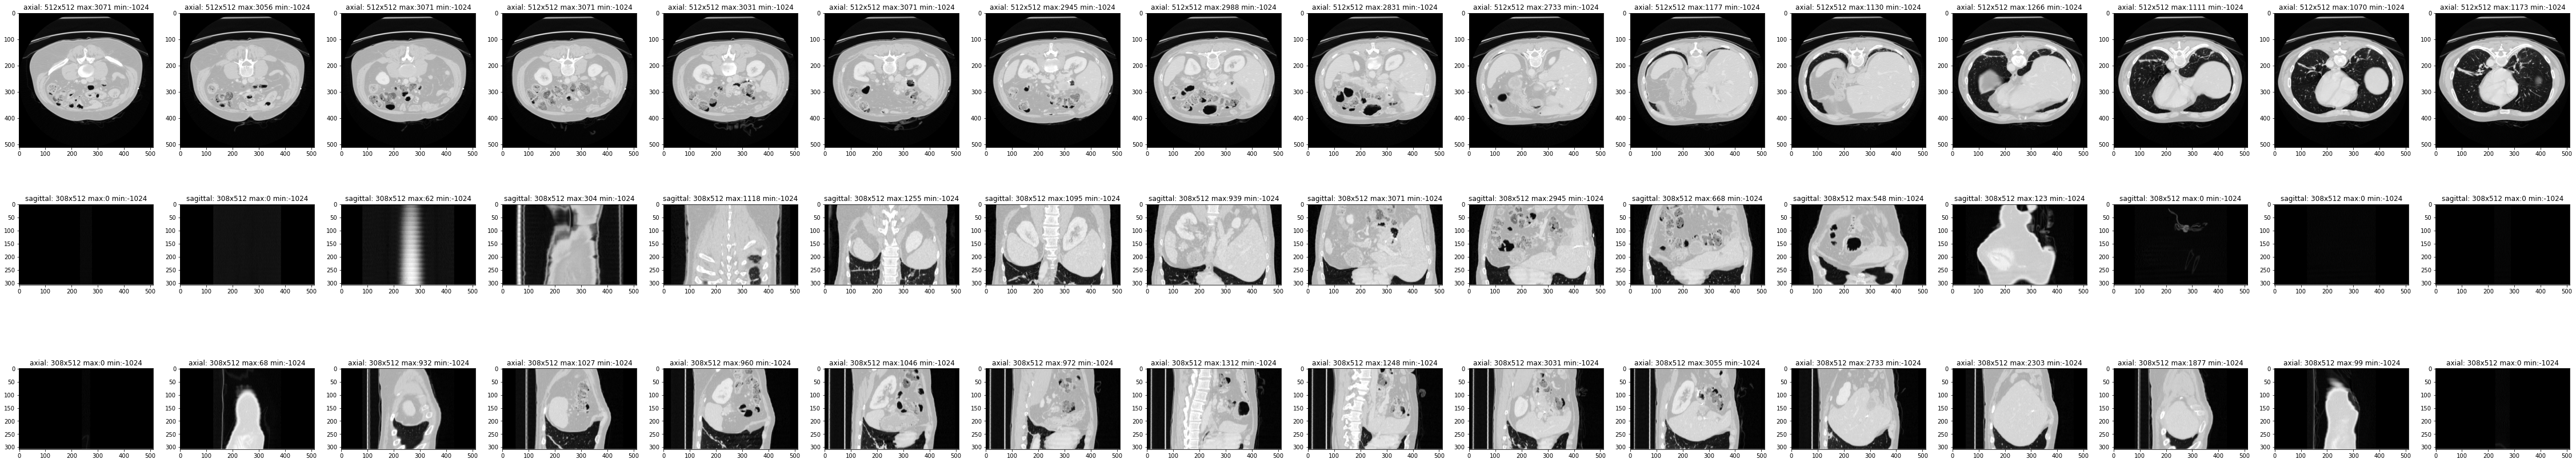

In [ ]:

"""
# Before attributes are loaded
image = image_p
print(image.memory)
pprint.pprint(image.__dict__, compact=True)
print(image.memory)
print(image.type)
print(image.is_vector)
print(image.sitk_type)

# Dictionary behavior
print(image.patient, image['patient'])
image.patient = 10101
print(image.patient, image['patient'])
image['patient'] = 20202
print(image.patient, image['patient'])

image.update({'pat': 0, 'med': 10})
print(image.pat, image.med)

image.update(shape=True)
# print(image.__dict__)
print(image.shape)
print(image['shape'])
"""

image = image_p
print(f"Memory Usage: {image.memory} bytes")

## Testing data retrieval
start = time.time()
array = image.array
print(f"{time.time() - start} sec")
print(array.shape, array.dtype, array.min(), array.max())

tensor = image.tensor
print(tensor.shape, tensor.dtype, tensor.min(), tensor.max())


## Plot
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(1, 1, 1)
# ax.imshow(array)
# plt.show()

print('-'*20, '\n', image)
image.plot()






### 2D Images & Masks (ISIC'17 example)

In [ ]:
### Picking image, container, and multi-modal loading
i = 5  # image index
perma = False
im_obj = VectorImage2D
stype = sitk.sitkVectorUInt8


im_sitk = sitk_list[i]
im_array = sitk.GetArrayFromImage(im_sitk)
im_tensor = torch.tensor(im_array)

print(im_array.shape, im_tensor.shape)
inputs = [image_dir / images[i], im_sitk, im_array, im_tensor]


image_p = im_obj(str(inputs[0]), stype, permanent_load=perma, 
              patient='1', machine='jj', accuracies=[1, 2, 3, 4, 5, 6, 7],
              other_random_list=[0]*300)
image_s = im_obj(inputs[1], stype, permanent_load=perma)
image_a = im_obj(inputs[2], stype, permanent_load=perma)
image_t = im_obj(inputs[3], stype, permanent_load=perma)

(2016, 3024, 3) torch.Size([2016, 3024, 3])
COSTLY!! UPDATING ATTRIBUTES!
COSTLY!! UPDATING ATTRIBUTES!
COSTLY!! UPDATING ATTRIBUTES!


Memory Usage: 18290320 bytes
0.002244710922241211 sec
(2016, 3024, 3) uint8 0 255
torch.Size([3, 2016, 3024]) torch.uint8 tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
-------------------- 
 VectorImage2D (gid=2) 
  Given Format (type=<class 'numpy.ndarray'>) 
  Type: vector of 8-bit unsigned integer, Shape [3024 2016], Spacing [1. 1.] 
  Origin [0. 0.], Direction [1. 0. 0. 1.] 
  Affine [1. 0. 0. 0. 1. 0. 0. 0. 1.] 
  Tot Mem = 18,290,320 bytes. 
Other Attributes: 
 {'_affine': array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]),
 '_direction': array([1., 0., 0., 1.]),
 '_origin': array([0., 0.]),
 '_shape': array([3024, 2016]),
 '_spacing': array([1., 1.]),
 'global_id': 2,
 'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x1122aa4e0> >} 



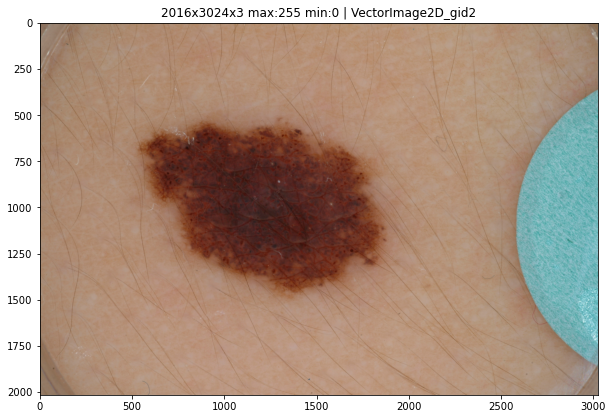

In [ ]:
image = image_a
print(f"Memory Usage: {image.memory} bytes")

## Testing data retrieval
start = time.time()
array = image.array
print(f"{time.time() - start} sec")
print(array.shape, array.dtype, array.min(), array.max())

tensor = image.tensor
print(tensor.shape, tensor.dtype, tensor.min(), tensor.max())


## Plot
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(1, 1, 1)
# ax.imshow(array)
# plt.show()

print('-'*20, '\n', image)
image.plot()

hi
COSTLY!! UPDATING ATTRIBUTES!
[418918 364956] [0.534 0.466] ['background', 'lesion']


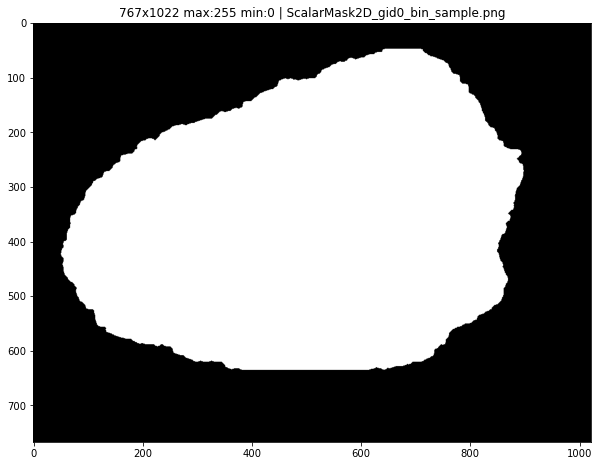

tensor([0, 1], dtype=torch.uint8)


In [ ]:
image_p = VectorImage2D(test_images_d['rgb'])

print('hi')
cns = ['background', 'lesion']
label_p = ScalarMask2D(test_images_d['bin'], cns, [0, 255])

print(label_p.class_counts, label_p.classes_distribution, label_p.class_names)
label_p.plot()

print(label_p.get_ids(tensor=True).unique())


### 3D Images & Mask Testing

In [ ]:
### Picking image, container, and multi-modal loading
i = 5  # image index
perma = True
im_obj, lab_obj = ScalarImage3D, ScalarMask3D
stype = sitk.sitkInt32


## 1st load labels & create containers for volumes
lab_dir = pathlib.Path('../Task07_Pancreas/labelsTr')
lab_images = sorted([f for f in os.listdir(lab_dir) if f[-2:] in ('gz', 'pg')])
cns = ['background', 'pancreas', 'tumor']

lab_sitk_list = []
for i, image in enumerate(tqdm(lab_images[:7])):
    image_path = lab_dir / image
    sitk_im = sitk.ReadImage(str(image_path), stype)
    lab_sitk_list.append(sitk_im)
tot_bytes = sum([get_image_memory(i, disp=False) for i in lab_sitk_list])
print(f'Total Memory: {tot_bytes / 1e6} MB (Current pid: {os.getpid()})')

lab_sitk = lab_sitk_list[i]
lab_array = sitk.GetArrayFromImage(lab_sitk)
lab_tensor = torch.tensor(lab_array)
print(lab_array.shape, lab_tensor.shape)
lab_inputs = [lab_dir / lab_images[i], lab_sitk, lab_array, lab_tensor]

label_p = lab_obj(str(lab_inputs[0]), cns, container_type=stype, 
              patient='1', machine='jj')
label_s = lab_obj(lab_inputs[1], cns, container_type=stype)
label_a = lab_obj(lab_inputs[2], cns, container_type=stype)
label_t = lab_obj(lab_inputs[3], cns, container_type=stype)


## Create containers for scans
im_sitk = sitk_list[i]
im_array = sitk.GetArrayFromImage(im_sitk)
im_tensor = torch.tensor(im_array)

print(im_array.shape, im_tensor.shape)
inputs = [image_dir / images[i], im_sitk, im_array, im_tensor]

image_p = im_obj(str(inputs[0]), stype, permanent_load=perma, 
              patient='1', machine='jj', accuracies=[1, 2, 3, 4, 5, 6, 7],
              other_random_list=[0]*300)
image_s = im_obj(inputs[1], stype, permanent_load=perma)
image_a = im_obj(inputs[2], stype, permanent_load=perma)
image_t = im_obj(inputs[3], stype, permanent_load=perma)

100%|██████████| 7/7 [00:00<00:00,  9.77it/s]


Total Memory: 204.47232 MB (Current pid: 56085)
(87, 512, 512) torch.Size([87, 512, 512])
COSTLY!! UPDATING ATTRIBUTES!
COSTLY!! UPDATING ATTRIBUTES!
COSTLY!! UPDATING ATTRIBUTES!
COSTLY!! UPDATING ATTRIBUTES!
(87, 512, 512) torch.Size([87, 512, 512])
COSTLY!! UPDATING ATTRIBUTES!
COSTLY!! UPDATING ATTRIBUTES!
COSTLY!! UPDATING ATTRIBUTES!
COSTLY!! UPDATING ATTRIBUTES!


In [ ]:
### Test 3D Mask basic attributes
print(label_p.array.shape, label_p.tensor.shape)
print(label_p.class_names, label_p.class_counts)
print(label_p.unique_values) 

print(image_p.tensor.shape)

print(label_p.class_names)

id_mask = label_p.get_id_map()
oh_mask = label_p.get_one_hot(channel_first=True)

(87, 512, 512) torch.Size([87, 512, 512])
['background', 'pancreas', 'tumor'] [22742106    58307     6115]
[0 1 2]
torch.Size([87, 512, 512])
['background', 'pancreas', 'tumor']


## A.2 Categorical Labels

In [ ]:
cns = ['a', 'b', 'c', 2.4, 2] 

mc = CategoricalLabel('a', cns, multi_label=False, asdf='asdf')
print(mc)
mc = CategoricalLabel('2', cns, multi_label=False)
print(mc)

mc = CategoricalLabel('2', cns, multi_label=True)
print(mc)
print(mc.get_ids(tensor=True).squeeze())

mc = CategoricalLabel(('2', 'a', 1), cns, multi_label=True)
print(mc)
print(mc.get_one_hot(tensor=True))

CategoricalLabel (multi-class, gid=59)
  Label: cls-ids=[0], cls-names=['a']
  5 classes: ['a', 'b', 'c', '2.4', '2']
Other Attributes: 
 { '_class_names': ['a', 'b', 'c', '2.4', '2'],
  '_given_label': 'a',
  '_ids': array([0], dtype=int32),
  '_multi_label': False,
  'asdf': 'asdf',
  'global_id': 59} 

CategoricalLabel (multi-class, gid=60)
  Label: cls-ids=[4], cls-names=['2']
  5 classes: ['a', 'b', 'c', '2.4', '2']
Other Attributes: 
 { '_class_names': ['a', 'b', 'c', '2.4', '2'],
  '_given_label': '2',
  '_ids': array([4], dtype=int32),
  '_multi_label': False,
  'global_id': 60} 

CategoricalLabel (multi-label, gid=61)
  Label: cls-ids=[4], cls-names=['2']
  5 classes: ['a', 'b', 'c', '2.4', '2']
Other Attributes: 
 { '_class_names': ['a', 'b', 'c', '2.4', '2'],
  '_given_label': '2',
  '_ids': array([4], dtype=int32),
  '_multi_label': True,
  'global_id': 61} 

tensor(4., dtype=torch.float64)
CategoricalLabel (multi-label, gid=62)
  Label: cls-ids=[0, 1, 4], cls-names=['a', '

## A.3 Samples & SampleSets

In [ ]:
## Realistic example: loading Task07_Pancreas

"""
Pancreas (task 07): took 86.9sec to load dataset (serial)
                    took 19.1sec to load via ThreadPoolExector
"""
import concurrent
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

train_dir = pathlib.Path('../Task07_Pancreas/imagesTr')
train_ims = sorted([f for f in os.listdir(train_dir) if f[-2:] =='gz'])
label_dir = pathlib.Path('../Task07_Pancreas/labelsTr')
label_ims = sorted([f for f in os.listdir(label_dir) if f[-2:] =='gz'])

assert len(train_ims) == len(label_ims)

## Create samples & sampleset


def create_sample(args):
    img_path, lab_path, name, idx = args
    cns = ['background', 'pancreas', 'tumor']
    image = ScalarImage3D(img_path, sitk.sitkInt16, 
                          permanent_load=False, name=name)
    label = ScalarMask3D(lab_path, cns, container_type=sitk.sitkUInt8)
    label2 = CategoricalLabel(random.randint(0, 2), cns)
    
    sample = Sample(image=image, label=label, cat=label2, name=name, id=idx)
    return sample

# using ray

@ray.remote
def create_sample(args):
    img_path, lab_path, name, idx = args
    cns = ['background', 'pancreas', 'tumor']
    image = ScalarImage3D(img_path, sitk.sitkInt16, 
                          permanent_load=False, name=name)
    label = ScalarMask3D(lab_path, cns, container_type=sitk.sitkUInt8)
    label2 = CategoricalLabel(random.randint(0, 2), cns)
    
    sample = Sample(image=image, label=label, cat=label2, name=name, id=idx)
    return sample

start = time.time()
results = []
for i in range(len(train_ims)):
    img_path = train_dir / train_ims[i]
    lab_dir = label_dir / label_ims[i]
    name = train_ims[i]
    args = (img_path, lab_dir, name, i)
    results.append(create_sample.remote(args))
samples = [ray.get(r) for r in results]
sampset = SampleSet(samples)
print(time.time() - start)

import sys; sys.exit(1)

start = time.time()
results = []
with ThreadPoolExecutor() as e:
    for i in range(len(train_ims)):
        img_path = train_dir / train_ims[i]
        lab_dir = label_dir / label_ims[i]
        name = train_ims[i]
        args = (img_path, lab_dir, name, i)
        results.append(e.submit(create_sample, args))
        # results.append(create_sample(args))

samples = [r.result() for r in results]
# samples = results
sampset = SampleSet(samples)
print(time.time() - start)

    


RayTaskError(RuntimeError): [36mray::create_sample()[39m (pid=9161, ip=10.31.223.37)
  File "python/ray/_raylet.pyx", line 501, in ray._raylet.execute_task
  File "/usr/local/lib/python3.9/site-packages/ray/_private/function_manager.py", line 184, in f
    raise RuntimeError(
RuntimeError: This function was not imported properly.

2021-07-15 22:15:15,854	ERROR worker.py:78 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::create_sample() (pid=9153, ip=10.31.223.37)
  File "python/ray/_raylet.pyx", line 501, in ray._raylet.execute_task
  File "/usr/local/lib/python3.9/site-packages/ray/_private/function_manager.py", line 184, in f
    raise RuntimeError(
RuntimeError: This function was not imported properly.
2021-07-15 22:15:15,856	ERROR worker.py:78 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::create_sample() (pid=9159, ip=10.31.223.37)
  File "python/ray/_raylet.pyx", line 501, in ray._raylet.execute_task
  File "/usr/local/lib/python3.9/site-packages/ray/_private/function_manager.py", line 184, in f
    raise RuntimeError(
RuntimeError: This function was not imported properly.
2021-07-15 22:15:15,857	ERROR worker.py:78 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::create_sample() (pid=9149, ip=10.31.223.37)
  File "python/ray/_raylet.pyx",

In [ ]:
print(sampset[0])
# sampset[0].__dict__
# print(issubclass(sampset[0]['image'], Image))
# print(sampset[0].get_images_dict())

Sample (gid=20) 
1 Image(s) 
  "image": ScalarImage3D (lazy-load, int16)
   "../Task07_Pancreas/imagesTr/pancreas_001.nii.gz"
1 Label(s) 
  "label": ScalarMask3D 
   Has ids: [0 1 2] 

